# Medical Text Mining for Disease Detection using Natural Language Processing

In [2]:
import os
import re
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import spacy
from spacy.matcher import Matcher
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('metadata.csv')

In [15]:
df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,url
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/006866
3,058r9486,4da8a87e614373d56070ed272487451266dce919,biorxiv,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,NaN,NaN,biorxiv,Deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/007476
4,wich35l7,eccef80cfbe078235df22398f195d5db462d8000,biorxiv,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,NaN,NaN,biorxiv,Developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/010389


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45774 entries, 0 to 45773
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cord_uid                     45774 non-null  object 
 1   sha                          31753 non-null  object 
 2   source_x                     45774 non-null  object 
 3   title                        45617 non-null  object 
 4   doi                          42440 non-null  object 
 5   pmcid                        26243 non-null  object 
 6   pubmed_id                    34641 non-null  float64
 7   license                      45774 non-null  object 
 8   abstract                     37912 non-null  object 
 9   publish_time                 45765 non-null  object 
 10  authors                      43774 non-null  object 
 11  journal                      41707 non-null  object 
 12  Microsoft Academic Paper ID  964 non-null    float64
 13  WHO #Covidence  

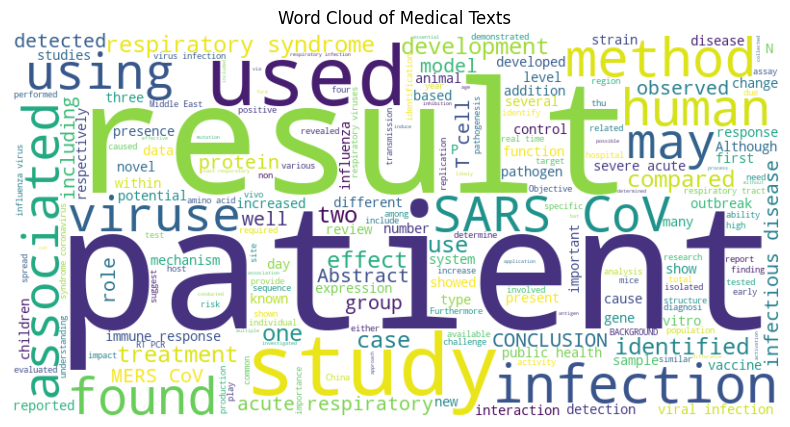

In [16]:
# Preprocessing: Select relevant columns and drop rows with missing values
df = df[['abstract', 'title', 'authors', 'journal']]
df.dropna(inplace=True)

# Combine abstract and title into a single text column
df['text'] = df['title'] + ' ' + df['abstract']

# Tokenization and word cloud
text_combined = ' '.join(df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Medical Texts')
plt.show()

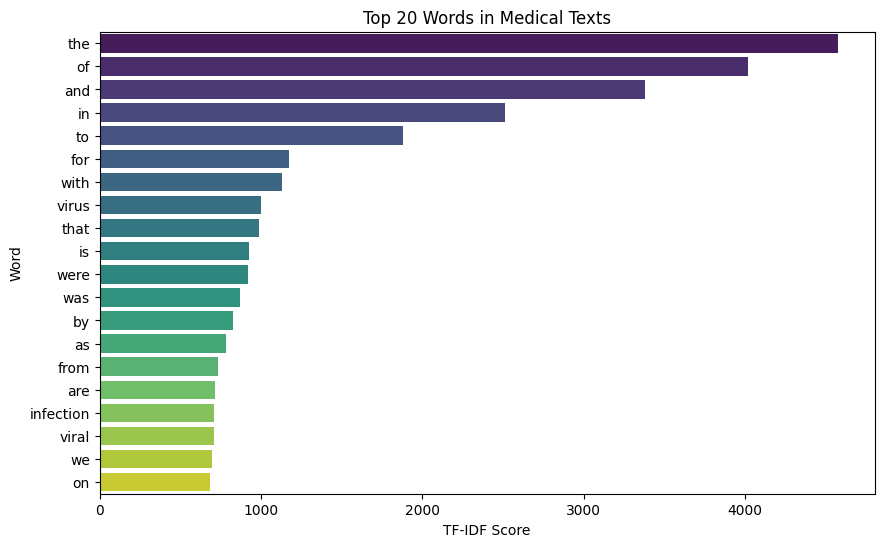

In [17]:

# Tokenization and bar chart for top words
vectorizer = TfidfVectorizer(max_features=5000)
X_vec = vectorizer.fit_transform(df['text'])

# Calculate TF-IDF scores for all words
tfidf_scores = pd.DataFrame(X_vec.toarray(), columns=vectorizer.get_feature_names_out())

# Sum TF-IDF scores across all documents
top_words = tfidf_scores.sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_words.values, y=top_words.index, palette='viridis')
plt.title('Top 20 Words in Medical Texts')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.show()



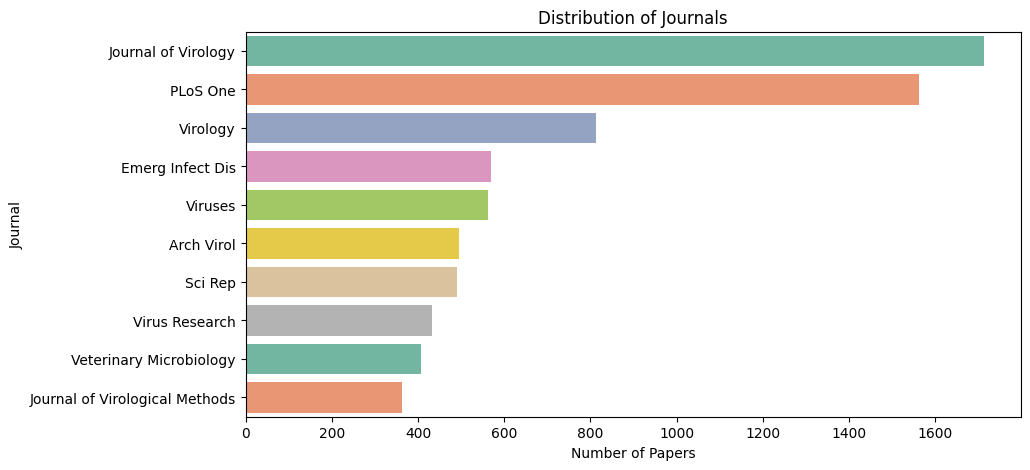

In [18]:
# Visualize journal distribution
plt.figure(figsize=(10, 5))
sns.countplot(y='journal', data=df, order=df['journal'].value_counts().index[:10], palette='Set2')
plt.title('Distribution of Journals')
plt.xlabel('Number of Papers')
plt.ylabel('Journal')
plt.show()


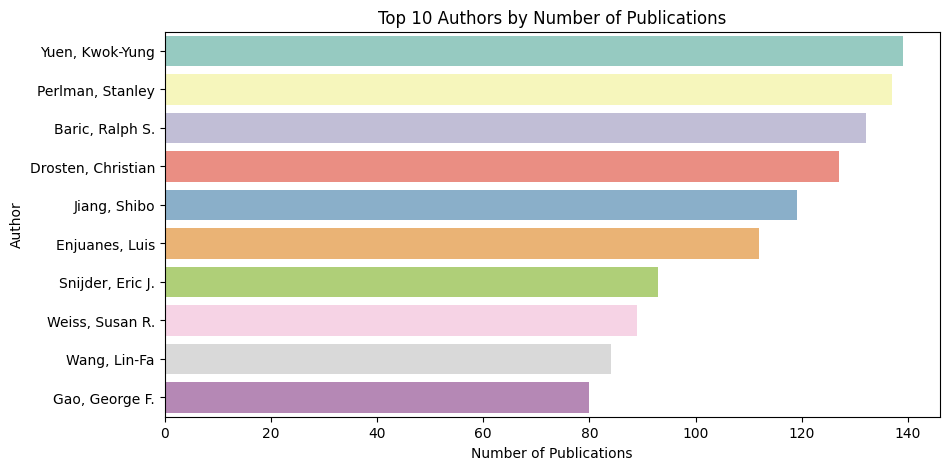

In [19]:

# Visualize authors with most publications
top_authors = df['authors'].str.split('; ', expand=True).stack().value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_authors.values, y=top_authors.index, palette='Set3')
plt.title('Top 10 Authors by Number of Publications')
plt.xlabel('Number of Publications')
plt.ylabel('Author')
plt.show()

In [69]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, Dataset
import joblib
import warnings
warnings.filterwarnings("ignore")


In [70]:

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Load the dataset
df = pd.read_csv('metadata.csv')

# Preprocessing: Select relevant columns and drop rows with missing values
df = df[['abstract', 'title', 'journal']]
df.dropna(inplace=True)

# Combine abstract and title into a single text column
df['text'] = df['title'] + ' ' + df['abstract']


In [71]:
# Tokenization and TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_vec = vectorizer.fit_transform(df['text'])

In [72]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vec, df['journal'], test_size=0.2, random_state=42)

# Filter out rows with labels not present in y_train
valid_indices = y_test.isin(y_train)
X_test_filtered = X_test[valid_indices]
y_test_filtered = y_test[valid_indices]

# Convert journal labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test_filtered)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_filtered.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Create custom datasets and data loaders
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [72]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vec, df['journal'], test_size=0.2, random_state=42)

# Filter out rows with labels not present in y_train
valid_indices = y_test.isin(y_train)
X_test_filtered = X_test[valid_indices]
y_test_filtered = y_test[valid_indices]

# Convert journal labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test_filtered)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_filtered.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Create custom datasets and data loaders
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [73]:
# Define the neural network model
class DiseaseDetectionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(DiseaseDetectionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class DiseaseDetectionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(DiseaseDetectionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define input size, hidden size, and number of classes
input_size = 100  # Example input size
hidden_size = 128  # Example hidden size
num_classes = 10  # Example number of classes

# Create an instance of your model
model = DiseaseDetectionModel(input_size, hidden_size, num_classes)

# Define a custom title for the model summary
title = "Disease Detection Model Summary\n" + "=" * 50

# Print the model summary with the custom title
print(title)
summary(model, (input_size,))


Disease Detection Model Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          12,928
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 10]           1,290
Total params: 14,218
Trainable params: 14,218
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [74]:
# Initialize the model, loss function, and optimizer
input_size = X_train_tensor.shape[1]
hidden_size = 128
num_classes = len(label_encoder.classes_)

model = DiseaseDetectionModel(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = []
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.tolist())

accuracy = accuracy_score(y_test_encoded.tolist(), y_pred)
print(f'Accuracy: {accuracy:.2f}')


# Save the trained model and vectorizer
torch.save(model.state_dict(), 'pytorch_disease_detection_model.pth')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


Epoch 1, Loss: 5604.456058979034
Epoch 2, Loss: 4851.584798812866
Epoch 3, Loss: 4368.212116241455
Epoch 4, Loss: 3911.9255969524384
Epoch 5, Loss: 3456.4397192001343
Epoch 6, Loss: 2986.1238255500793
Epoch 7, Loss: 2505.1204228401184
Epoch 8, Loss: 2026.9089385271072
Epoch 9, Loss: 1566.2568119764328
Epoch 10, Loss: 1156.0210949778557
Accuracy: 0.24


['tfidf_vectorizer.pkl']

In [75]:

# Classification report and confusion matrix
print(classification_report(y_test_encoded.tolist(), y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test_encoded.tolist(), y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         2
          17       1.00      0.50      0.67         2
          19       0.00      0.00      0.00         2
          20       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         1
          26       0.00      0.00      0.00         1
          27       0.00      0.00      0.00         2
          31       0.00      0.00      0.00         0
          32       0.00      0.00      0.00         2
          37       0.00      0.00      0.00         1
          39       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          43       0.00      0.00      0.00         1
          45       0.50      0.33      0.40         3
          46       1.00      0.80      0.89         5
          48       0.00    

# Model 2: Information Classification Model

In [13]:
import pandas as pd
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import joblib
import warnings
warnings.filterwarnings("ignore")


# Load the CSV file into a pandas DataFrame
data = pd.read_csv('Medical Data.csv')

# View the first few rows of the DataFrame
data.head()


,Row,Diseases and Conditions,Symptoms,Medications,Procedures,Laboratory Tests and Results,Patient Demographics,Temporal Information,Clinical Outcomes,Sentiment Analysis,Biomedical Knowledge
0,1,Diabetes mellitus,"Fatigue, Polyuria","Metformin, Insulin",Blood glucose monitoring,"HbA1c 7.2%, Fasting glucose 150 mg/dL","Age: 55, Gender: Male",Diagnosis date: 2010,Improved symptoms,Positive feedback,Association between diabetes and obesity
1,2,Hypertension,"Headache, Dizziness","Lisinopril, Amlodipine",Blood pressure monitoring,"BP 140/90 mmHg, Heart rate 75 bpm","Age: 65, Gender: Female",Onset of symptoms: 2015,Stable condition,Neutral feedback,Link between hypertension and kidney disease
2,3,Asthma,"Shortness of breath, Wheezing","Albuterol, Fluticasone",Pulmonary function test,"FEV1 70%, Peak flow rate 300 L/min","Age: 40, Gender: Non-binary",Last hospitalization: 2022,Exacerbation,Negative feedback,Effectiveness of inhaler therapy
3,4,Rheumatoid arthritis,"Joint pain, Swelling","Methotrexate, Prednisone",Joint aspiration,"ESR 30 mm/hr, CRP 8 mg/L","Age: 50, Gender: Female",Disease onset: 2005,Remission,Positive feedback,Association between RA and cardiovascular risk
4,5,Gastroesophageal reflux disease,"Heartburn, Regurgitation","Omeprazole, Ranitidine",Upper endoscopy,Esophagitis grade A,"Age: 30, Gender: Male",Last endoscopy: 2023,Improved symptoms,Positive feedback,Correlation between GERD and diet


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Row                           150 non-null    int64 
 1   Diseases and Conditions       150 non-null    object
 2   Symptoms                      150 non-null    object
 3   Medications                   150 non-null    object
 4   Procedures                    150 non-null    object
 5   Laboratory Tests and Results  150 non-null    object
 6   Patient Demographics          150 non-null    object
 7   Temporal Information          150 non-null    object
 8   Clinical Outcomes             150 non-null    object
 9   Sentiment Analysis            150 non-null    object
 10  Biomedical Knowledge          150 non-null    object
dtypes: int64(1), object(10)
memory usage: 13.0+ KB


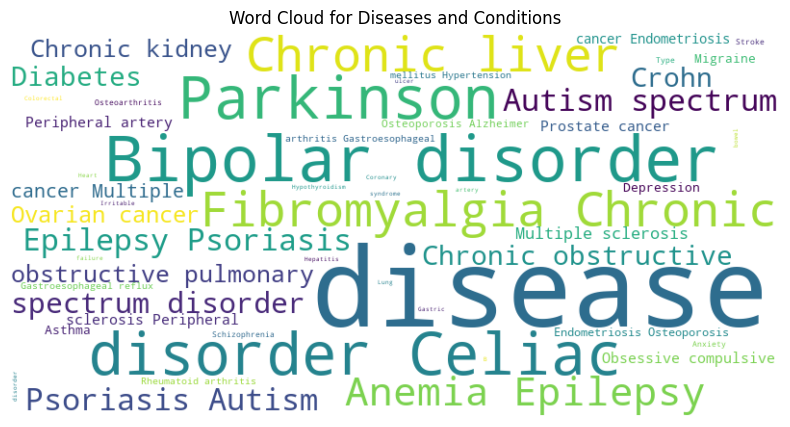

In [17]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all text from the 'Diseases and Conditions' column into a single string
text = ' '.join(data['Diseases and Conditions'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Diseases and Conditions')
plt.show()

In [ ]:

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]



In [ ]:
# Load the dataset
df = pd.read_csv('Medical Data.csv')

# Preprocessing: Select relevant columns and drop rows with missing values
df = df[['Diseases and Conditions', 'Symptoms', 'Medications', 'Procedures',
         'Laboratory Tests and Results', 'Patient Demographics', 'Temporal Information',
         'Clinical Outcomes', 'Sentiment Analysis', 'Biomedical Knowledge']]
df.dropna(inplace=True)

# One-hot encode the target labels
y_labels = pd.get_dummies(df, columns=['Diseases and Conditions', 'Symptoms', 'Medications', 'Procedures',
                                       'Laboratory Tests and Results', 'Patient Demographics', 'Temporal Information',
                                       'Clinical Outcomes', 'Sentiment Analysis', 'Biomedical Knowledge'])

# Tokenization and TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_vec = vectorizer.fit_transform(df['Sentiment Analysis'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_labels, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create custom datasets and data loaders
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:

# Define the neural network model
class InformationClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(InformationClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

# Initialize the model, loss function, and optimizer
input_size = X_train_tensor.shape[1]
hidden_size = 128

In [26]:
output_size = y_train_tensor.shape[1]

model = InformationClassificationModel(input_size, hidden_size, output_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = []
    for inputs, targets in test_loader:
        outputs = model(inputs)
        y_pred.extend(outputs.round().tolist())

# Save the trained model and vectorizer
torch.save(model.state_dict(), 'pytorch_information_classification_model.pth')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(y_labels.columns.tolist(), 'information_labels.pkl')


Epoch 1, Loss: 2.7319105863571167
Epoch 2, Loss: 2.5879573225975037
Epoch 3, Loss: 2.447622001171112
Epoch 4, Loss: 2.3068504333496094
Epoch 5, Loss: 2.1652225255966187
Epoch 6, Loss: 2.028438091278076
Epoch 7, Loss: 1.8892907798290253
Epoch 8, Loss: 1.7527998387813568
Epoch 9, Loss: 1.6240314841270447
Epoch 10, Loss: 1.4971559941768646


['information_labels.pkl']

In [4]:
import torch
import torch.nn as nn
from torchsummary import summary

class InformationClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(InformationClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

# Define input size, hidden size, and output size
input_size = 100  # Example input size
hidden_size = 128  # Example hidden size
output_size = 3  # Example output size

# Create an instance of your model
model = InformationClassificationModel(input_size, hidden_size, output_size)

# Define a custom title for the model summary
title = "Information Classification Model Summary\n" + "=" * 50

# Print the model summary with the custom title
print(title)
summary(model, (input_size,))


Information Classification Model Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          12,928
              ReLU-2                  [-1, 128]               0
            Linear-3                    [-1, 3]             387
           Sigmoid-4                    [-1, 3]               0
Total params: 13,315
Trainable params: 13,315
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
df = pd.read_csv('Medical Data.csv')

# Preprocessing: Select relevant columns and drop rows with missing values
df = df[['Diseases and Conditions', 'Symptoms', 'Medications', 'Procedures',
         'Laboratory Tests and Results', 'Patient Demographics', 'Temporal Information',
         'Clinical Outcomes', 'Sentiment Analysis', 'Biomedical Knowledge']]
df.dropna(inplace=True)

# Tokenization and TF-IDF vectorization for future use
vectorizer = TfidfVectorizer(max_features=5000)
X_vec = vectorizer.fit_transform(df['Diseases and Conditions'] + ' ' +
                                 df['Symptoms'] + ' ' +
                                 df['Medications'] + ' ' +
                                 df['Procedures'] + ' ' +
                                 df['Laboratory Tests and Results'] + ' ' +
                                 df['Patient Demographics'] + ' ' +
                                 df['Temporal Information'] + ' ' +
                                 df['Clinical Outcomes'] + ' ' +
                                 df['Sentiment Analysis'] + ' ' +
                                 df['Biomedical Knowledge'])

# Save the vectorizer for future use
import joblib
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import joblib

# Load the dataset
df = pd.read_csv('Medical Data.csv')

# Preprocessing: Select relevant columns and drop rows with missing values
df = df[['Diseases and Conditions', 'Symptoms', 'Medications', 'Procedures',
         'Laboratory Tests and Results', 'Patient Demographics', 'Temporal Information',
         'Clinical Outcomes', 'Sentiment Analysis', 'Biomedical Knowledge']]
df.dropna(inplace=True)

# Combine text data into a single column for classification
df['text'] = df.apply(lambda row: ' '.join(row.dropna()), axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['Diseases and Conditions'], test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train the model
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# Evaluate the model
y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

# Save the trained model and vectorizer
joblib.dump(model, 'medical_text_classification_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


Accuracy: 0.8333333333333334
Classification Report:
                                       precision    recall  f1-score   support

                  Alzheimer's disease       1.00      1.00      1.00         1
             Autism spectrum disorder       1.00      1.00      1.00         2
                     Bipolar disorder       0.50      1.00      0.67         1
                       Celiac disease       1.00      1.00      1.00         2
               Chronic kidney disease       1.00      1.00      1.00         1
Chronic obstructive pulmonary disease       1.00      1.00      1.00         1
                      Crohn's disease       0.50      1.00      0.67         1
                    Diabetes mellitus       0.00      0.00      0.00         0
                        Endometriosis       1.00      1.00      1.00         1
                             Epilepsy       1.00      1.00      1.00         2
                         Fibromyalgia       1.00      1.00      1.00         1

['tfidf_vectorizer.pkl']

# MODELS COMPARISON

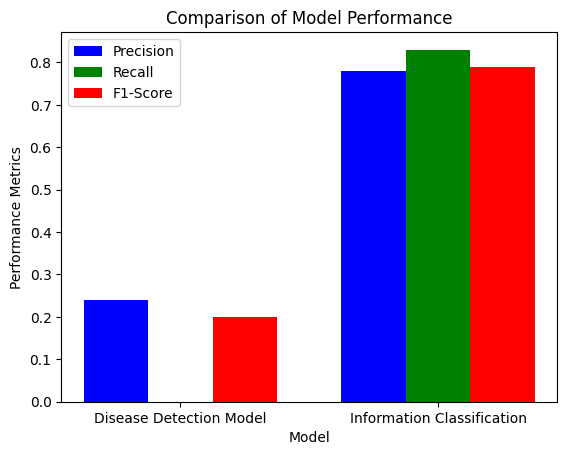

In [6]:
import matplotlib.pyplot as plt

# Define model names and performance metrics
models = ['Disease Detection Model', 'Information Classification']
precision = [0.24, 0.78]
recall = [0, 0.83]  # Recall value for Disease Detection Model is not provided, using 0 for visualization
f1_score = [0.20, 0.79]

# Set the width of the bars
bar_width = 0.25

# Set the position of each bar on the X-axis
r1 = range(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar chart
plt.bar(r1, precision, color='b', width=bar_width, label='Precision')
plt.bar(r2, recall, color='g', width=bar_width, label='Recall')
plt.bar(r3, f1_score, color='r', width=bar_width, label='F1-Score')

# Add labels, title, and legend
plt.xlabel('Model')
plt.ylabel('Performance Metrics')
plt.title('Comparison of Model Performance')
plt.xticks([r + bar_width for r in range(len(models))], models)
plt.legend()

# Show the plot
plt.show()


# DEPLOYMENT

In [16]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=10)

# Define the label mapping
label_mapping = ['Diseases and Conditions', 'Symptoms', 'Medications', 'Procedures',
                 'Laboratory Tests and Results', 'Patient Demographics', 'Temporal Information',
                 'Clinical Outcomes', 'Sentiment Analysis', 'Biomedical Knowledge']

# Input text to be classified
input_text = "head ache and coughing"

# Tokenize and convert to tensor
inputs = tokenizer(input_text, return_tensors='pt')
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

# Perform inference
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)

# Get the predicted labels
predicted_labels = torch.argmax(outputs.logits, dim=1)
predicted_label = label_mapping[predicted_labels[0]]

# Print the input text and its classification result
print("Input Text:", input_text)
print("Classification Result:", predicted_label)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Input Text: head ache and coughing
Classification Result: Symptoms


In [14]:
#### from ipywidgets import widgets, VBox, HBox, Layout

# Define input and output widgets
input_text = widgets.Textarea(placeholder='Enter text for grouping', layout=Layout(width='80%', height='100px'))
group_button = widgets.Button(description='Group', button_style='success')
clear_button = widgets.Button(description='Clear', button_style='warning')
exit_button = widgets.Button(description='Exit', button_style='danger')
output1_text = widgets.Output()
output2_text = widgets.Output()
output3_text = widgets.Output()
output4_text = widgets.Output()

# Grouping function
def group_text(text):
    text_lower = text.lower()
    groups = []
    if 'disease' in text_lower:
        groups.append('Disease')
    if 'symptom' in text_lower:
        groups.append('Symptom')
    if 'patient details' in text_lower:
        groups.append('Patient Details')
    if 'age' in text_lower:
        groups.append('Age')
    if not groups:
        groups.append('Other')
    return groups

# Grouping button click event
def on_group_button_click(b):
    output1_text.clear_output()
    output2_text.clear_output()
    output3_text.clear_output()
    output4_text.clear_output()
    with output1_text, output2_text, output3_text, output4_text:
        results = group_text(input_text.value)
        for result in results:
            print('Grouping Result:', result)

# Clear button click event
def on_clear_button_click(b):
    input_text.value = ''
    output1_text.clear_output()
    output2_text.clear_output()
    output3_text.clear_output()
    output4_text.clear_output()

# Exit button click event
def on_exit_button_click(b):
    input_text.close()
    group_button.close()
    clear_button.close()
    exit_button.close()
    output1_text.close()
    output2_text.close()
    output3_text.close()
    output4_text.close()

group_button.on_click(on_group_button_click)
clear_button.on_click(on_clear_button_click)
exit_button.on_click(on_exit_button_click)

# Arrange widgets in a vertical box layout
box_layout = Layout(display='flex', flex_flow='column', align_items='center')
vbox = VBox([input_text, HBox([group_button, clear_button, exit_button]), 
             output1_text, output2_text, output3_text, output4_text], layout=box_layout)

display(vbox)


In [15]:
from transformers import BertTokenizer, BertForSequenceClassification
from ipywidgets import widgets, VBox, HBox, Layout
import torch

# Load BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Define input and output widgets
input_text = widgets.Text(placeholder='Enter text for classification', layout=Layout(width='50%'))
classify_button = widgets.Button(description='Classify', button_style='success')
clear_button = widgets.Button(description='Clear', button_style='warning')
exit_button = widgets.Button(description='Exit', button_style='danger')
output_text = widgets.Output()

# Classification function
def classify_text(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    class_labels = ['Disease', 'Symptom']  # Example class labels, modify as needed
    return class_labels[predicted_class]

# Classification button click event
def on_classify_button_click(b):
    output_text.clear_output()
    with output_text:
        result = classify_text(input_text.value)
        print('Classification Result:', result)

# Clear button click event
def on_clear_button_click(b):
    input_text.value = ''
    output_text.clear_output()

# Exit button click event
def on_exit_button_click(b):
    input_text.close()
    classify_button.close()
    clear_button.close()
    exit_button.close()
    output_text.close()

classify_button.on_click(on_classify_button_click)
clear_button.on_click(on_clear_button_click)
exit_button.on_click(on_exit_button_click)

# Arrange widgets in a vertical box layout
box_layout = Layout(display='flex', flex_flow='column', align_items='center', width='50%')
vbox = VBox([input_text, HBox([classify_button, clear_button, exit_button]), output_text], layout=box_layout)

display(vbox)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
